In [1]:
import numpy as np
import pylab as plt
import torch

import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)
np.random.seed(0)

Generate Training Data for simple power law with noise

Take function: x = 10^$\alpha$ + $\epsilon$ , where
$\alpha \sim \mathcal{U}(-20, -5)$
$\epsilon \sim \mathcal{N}(\mu = alpha, \sigma = 0.1)$

We will be interested in the posterior distribution of alpha given an observation of x

In [20]:
N = 10_000  # Number of samples
a = np.random.rand(N, 1)*15-25  # Uniform prior over [-20, -5]
x = np.exp(a) #N by 1 array, normal w/ variance of 0.2

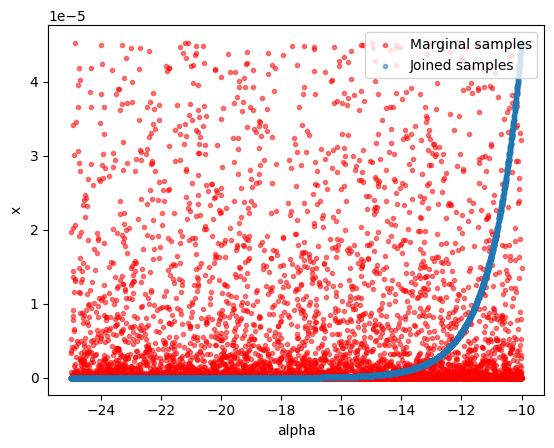

In [21]:
plt.scatter(a[:,0], np.random.permutation(x[:,0]), alpha = 0.5, marker='.', color='r', label = "Marginal samples"); plt.xlabel("alpha"); plt.ylabel("x");
plt.scatter(a[:,0], x[:,0], alpha = 0.5, marker='.', label = "Joined samples"); plt.xlabel("alpha"); plt.ylabel("x"); plt.legend(loc = 1)

In [22]:
#Storing Samples
samples = swyft.Samples(x = x, a = a)

In [24]:
# Defining Network for Ratios
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 1, varnames = 'a', num_blocks = 4) #Posterior for z?

    def forward(self, A, B):
        return self.logratios(A['x'], B['a'])

In [25]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cac

In [26]:
dm = swyft.SwyftDataModule(samples, batch_size=128)

In [27]:
network = Network()
trainer.fit(network, dm)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 34.6 K
-----------------------------------------------------
34.6 K    Trainable params
0         Non-trainable params
34.6 K    Total params
0.276     Total estimated model params size (MB)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: 

Epoch 16: 100%|██████████| 79/79 [00:01<00:00, 39.60it/s, loss=0.000424, v_num=3, val_loss=6.03e-5]  
Reloading best model: /Users/abbystokes/Documents/GitHub/DSMMA-Research/lightning_logs/version_3/checkpoints/epoch=11-step=756.ckpt


In [39]:
x0 = 0
obs = swyft.Sample(x = np.array([x0]))

In [40]:
prior_samples = swyft.Samples(a = np.random.rand(5000, 1)*15-25)

In [41]:
predictions = trainer.infer(network, obs, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 49.31it/s]


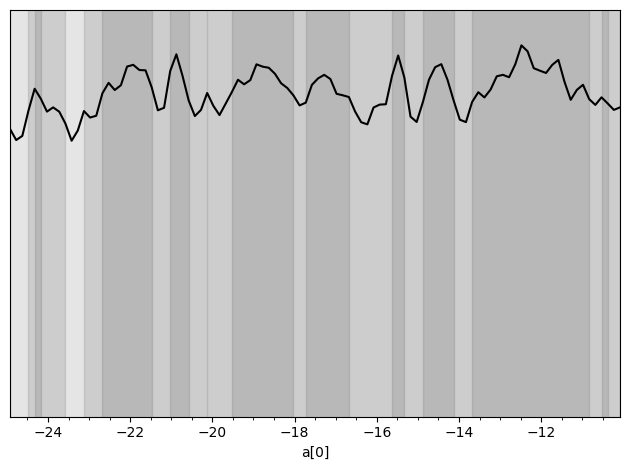

In [42]:
swyft.plot_posterior(predictions, 'a[0]', smooth = 1)
#for offset in [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]:
 #   plt.axvline(x0+offset, color='g', ls = ':')
plt.axvline(x0)